In [5]:
import numpy as np 
import pandas as pd

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib.pylab import rcParams

plt.style.use('ggplot')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import itertools
import statsmodels.api as sm
import operator

from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix

import time

In [6]:
def plot_confusion(y_test,y_pred_test):
    from sklearn.metrics import confusion_matrix
    c_matrix = confusion_matrix(y_test, y_pred_test)
    
    f, ax = plt.subplots(figsize=(5,5))
    sns.heatmap(c_matrix,fmt=".0f", annot=True,linewidths=0.2, linecolor="purple", ax=ax)
    plt.xlabel("Prediction")
    plt.ylabel("Actual")
    plt.show() 

In [7]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center',color='#1c3290') 
#     plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.yticks(np.arange(n_features), X.columns.values) 
    plt.xlabel('Feature importance', fontsize=20)
    plt.ylabel('Feature',fontsize=20)

In [8]:
def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        f1 = f1_score(y_test, preds)
        if f1 > best_score:
            best_k = k
            best_score = f1
    
    print("Best Value for k: {}".format(best_k))

In [9]:
def results(names,performance,kind):
    size = len(names)
    final = {}
    
    for i in range(size):
        final.update({names[i]: performance[i]})
        
    sorted_d = sorted(final.items(), key=lambda x: (x[1],x[0]), reverse=True)
    top = sorted_d[:1]
#     print(top)
    bottom = sorted_d[1:]
#     print(bottom)

    x1_val = [x[0] for x in top]
    y1_val = [x[1] for x in top]
    x2_val = [x[0] for x in bottom]
    y2_val = [x[1] for x in bottom]

    fig, ax = plt.subplots(figsize=(20,10))
    #fig, ax = plt.subplots(figsize=(20,10))
    plt.bar(x1_val,y1_val,color = '#1c3290', label="Top model")
    plt.bar(x2_val,y2_val, color = "#907A1C", label="")
#     plt.title("Top 10 US Zip Codes", fontsize = 35)
    plt.xticks(rotation=45, fontsize=15)
    plt.xlabel("Models", fontsize=20)
    plt.ylabel("{} %".format(kind), fontsize = 20)
    plt.legend()
    plt.show()

In [10]:
df = pd.read_csv("cardio_train.csv",sep=";")
df_control = pd.read_csv("cardio_train.csv",sep=";")

In [11]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [13]:
df.describe()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,19468.865814,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,2467.251667,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,10798.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,17664.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,19703.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,21327.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,23713.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


In [14]:
df['cardio'].value_counts()

0    35021
1    34979
Name: cardio, dtype: int64

In [15]:
df.drop("id",axis=1,inplace=True)

In [16]:
df.isna().sum()

age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

In [17]:
print("There are {} duplicated values in this dataset.".format(df.duplicated().sum()))

There are 24 duplicated values in this dataset.


In [18]:
duplicates = df[df.duplicated(keep=False)]

In [19]:
duplicates.sort_values(by=['age']).head(6)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
40365,14552,1,158,64.0,120,80,1,1,0,0,1,0
6325,14552,1,158,64.0,120,80,1,1,0,0,1,0
64169,16160,1,168,65.0,120,80,1,1,0,0,1,1
17101,16160,1,168,65.0,120,80,1,1,0,0,1,1
1204,16793,1,165,68.0,120,80,1,1,0,0,1,0
21784,16793,1,165,68.0,120,80,1,1,0,0,1,0


In [20]:
df.drop_duplicates(inplace=True)

In [21]:
print("Now there are {} duplicated values in this dataset.".format(df.duplicated().sum()))

Now there are 0 duplicated values in this dataset.


In [22]:
df['age'] = df['age'].map(lambda x : x // 365)
df.head(5)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,47,1,156,56.0,100,60,1,1,0,0,0,0


<AxesSubplot:xlabel='weight', ylabel='Density'>

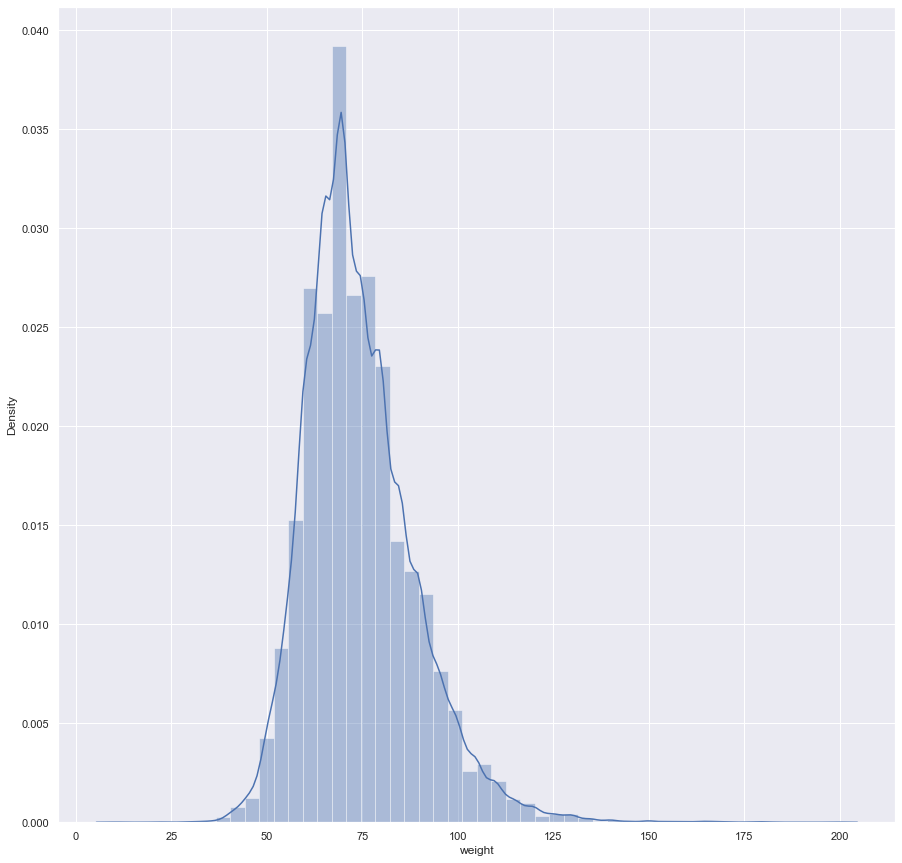

In [23]:
sns.set(rc={'figure.figsize':(15,15)})
sns.distplot(df['weight'])

In [24]:
lo_weight_outlier = df.loc[df['weight'] < 30 ]
lo_weight_outlier

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
26806,63,1,157,23.0,110,80,1,1,0,0,1,0
29488,55,2,177,22.0,120,80,1,1,1,1,1,0
33817,59,2,178,11.0,130,90,1,1,0,0,1,1
34276,40,2,128,28.0,120,80,1,1,0,0,1,0
57858,51,2,165,10.0,180,1100,2,2,0,0,1,1
60188,59,1,162,21.0,120,80,2,1,0,0,1,1
60699,51,1,171,29.0,110,70,2,1,0,0,1,1


In [25]:
temp = df[df['weight'] < 30].index
df.drop(temp,inplace=True)

In [26]:
hi_weight_outlier = df.loc[df['weight'] > 180 ]
hi_weight_outlier

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
435,45,1,186,200.0,130,70,1,1,0,0,0,0
36780,53,1,161,181.0,180,1100,2,1,0,0,1,1
50413,41,2,180,200.0,150,90,1,1,0,0,1,1
61285,57,2,180,183.0,110,80,3,3,0,1,1,1


<AxesSubplot:xlabel='ap_hi', ylabel='Density'>

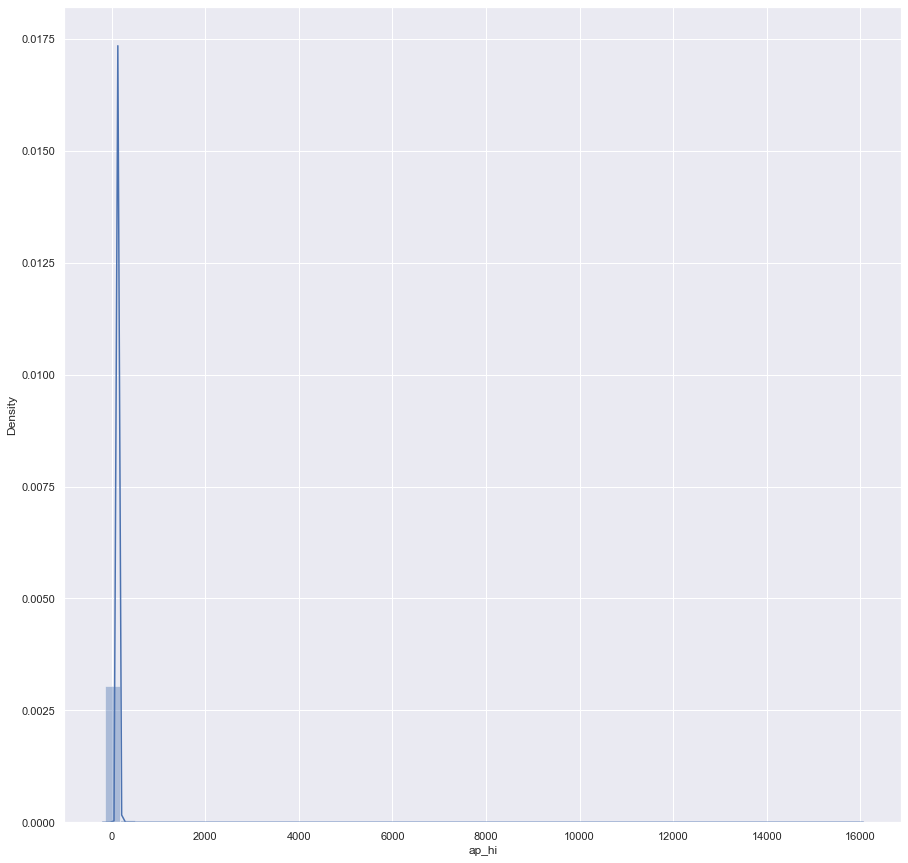

In [27]:
sns.set(rc={'figure.figsize':(15,15)})
sns.distplot(df['ap_hi'])

In [28]:
lo_ap_hi_outlier = df.loc[df['ap_hi'] < 20 ]
lo_ap_hi_outlier.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
567,58,1,168,78.0,14,90,2,1,0,0,1,1
927,59,2,175,70.0,14,90,3,1,0,0,1,1
979,49,1,172,65.0,11,80,1,3,0,0,1,0
1600,52,1,165,66.0,12,80,1,1,0,0,1,0
1627,61,1,165,71.0,14,80,1,1,0,0,1,1


In [29]:
hi_ap_hi_outlier = df.loc[df['ap_hi'] > 300]
hi_ap_hi_outlier.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40 entries, 1876 to 69370
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          40 non-null     int64  
 1   gender       40 non-null     int64  
 2   height       40 non-null     int64  
 3   weight       40 non-null     float64
 4   ap_hi        40 non-null     int64  
 5   ap_lo        40 non-null     int64  
 6   cholesterol  40 non-null     int64  
 7   gluc         40 non-null     int64  
 8   smoke        40 non-null     int64  
 9   alco         40 non-null     int64  
 10  active       40 non-null     int64  
 11  cardio       40 non-null     int64  
dtypes: float64(1), int64(11)
memory usage: 4.1 KB


In [30]:
df = df.drop(df[(df.ap_hi < 30) | (df.ap_hi > 300)].index)

<AxesSubplot:xlabel='ap_hi', ylabel='Density'>

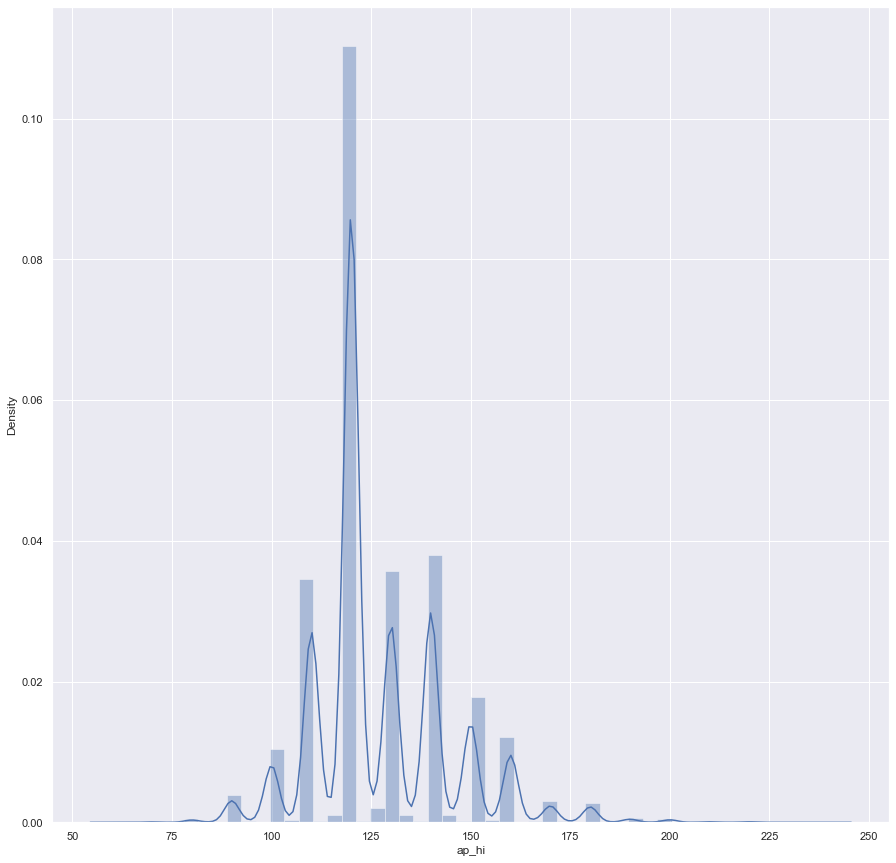

In [31]:
sns.set(rc={'figure.figsize':(15,15)})
sns.distplot(df['ap_hi'])

<AxesSubplot:xlabel='ap_lo', ylabel='Density'>

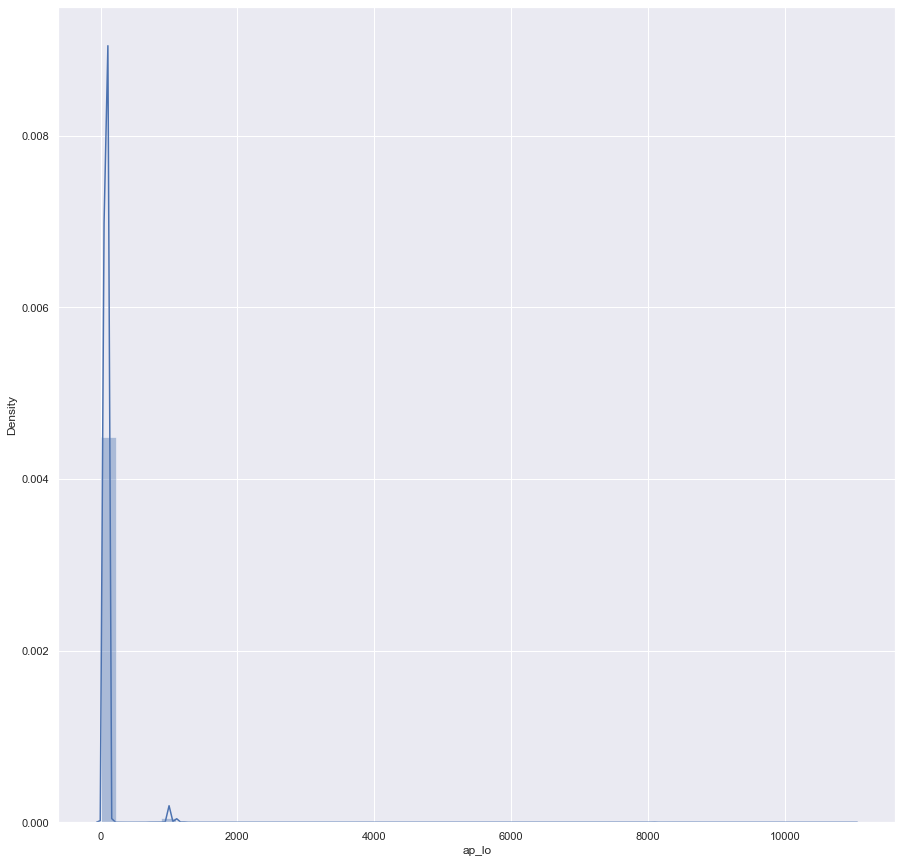

In [32]:
sns.set(rc={'figure.figsize':(15,15)})
sns.distplot(df['ap_lo'])

In [33]:
lo_ap_lo_outlier = df.loc[df['ap_lo'] <= 20 ]
lo_ap_lo_outlier.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
6737,45,1,156,61.0,150,10,1,1,0,0,0,1
7598,40,2,70,72.0,120,8,1,1,0,0,1,0
8797,57,1,162,68.0,110,20,1,1,0,0,1,0
9777,59,1,166,125.0,120,8,3,1,0,0,1,1
10106,50,1,152,50.0,150,10,3,1,0,0,1,1


In [34]:
hi_ap_lo_outlier = df.loc[df['ap_lo'] > 200 ]
hi_ap_lo_outlier.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 949 entries, 228 to 69967
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          949 non-null    int64  
 1   gender       949 non-null    int64  
 2   height       949 non-null    int64  
 3   weight       949 non-null    float64
 4   ap_hi        949 non-null    int64  
 5   ap_lo        949 non-null    int64  
 6   cholesterol  949 non-null    int64  
 7   gluc         949 non-null    int64  
 8   smoke        949 non-null    int64  
 9   alco         949 non-null    int64  
 10  active       949 non-null    int64  
 11  cardio       949 non-null    int64  
dtypes: float64(1), int64(11)
memory usage: 96.4 KB


In [35]:
df = df.drop(df[(df.ap_lo < 30) | (df.ap_lo > 200)].index)

<AxesSubplot:xlabel='ap_lo', ylabel='Density'>

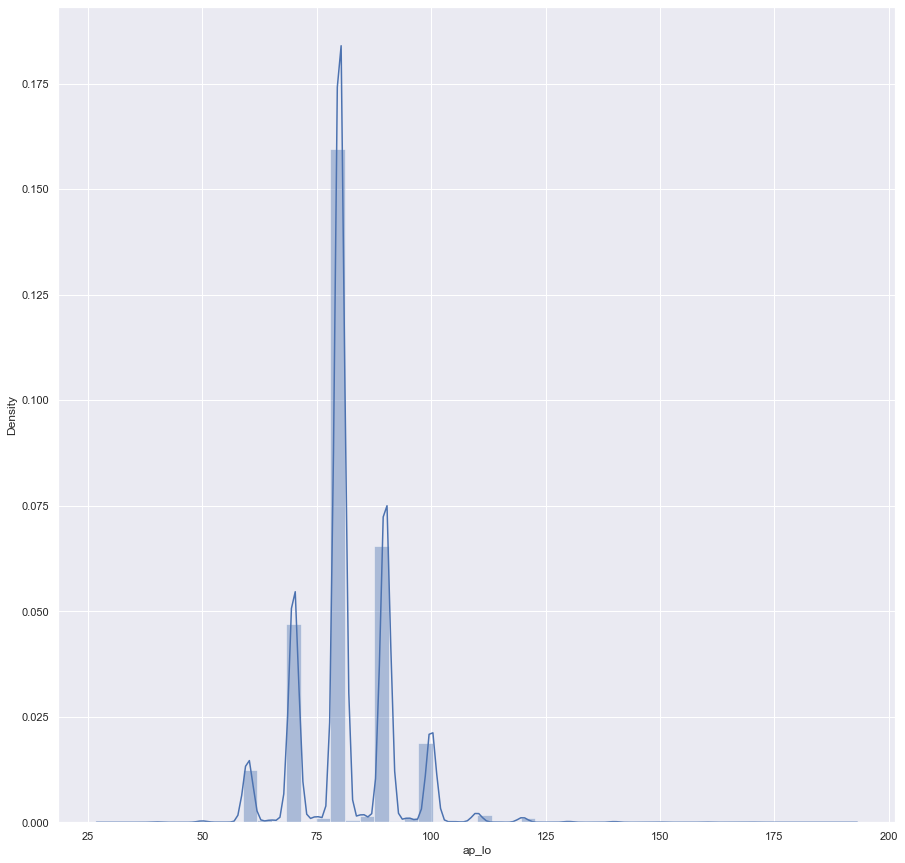

In [36]:
sns.set(rc={'figure.figsize':(15,15)})
sns.distplot(df['ap_lo'])

<AxesSubplot:xlabel='height', ylabel='Density'>

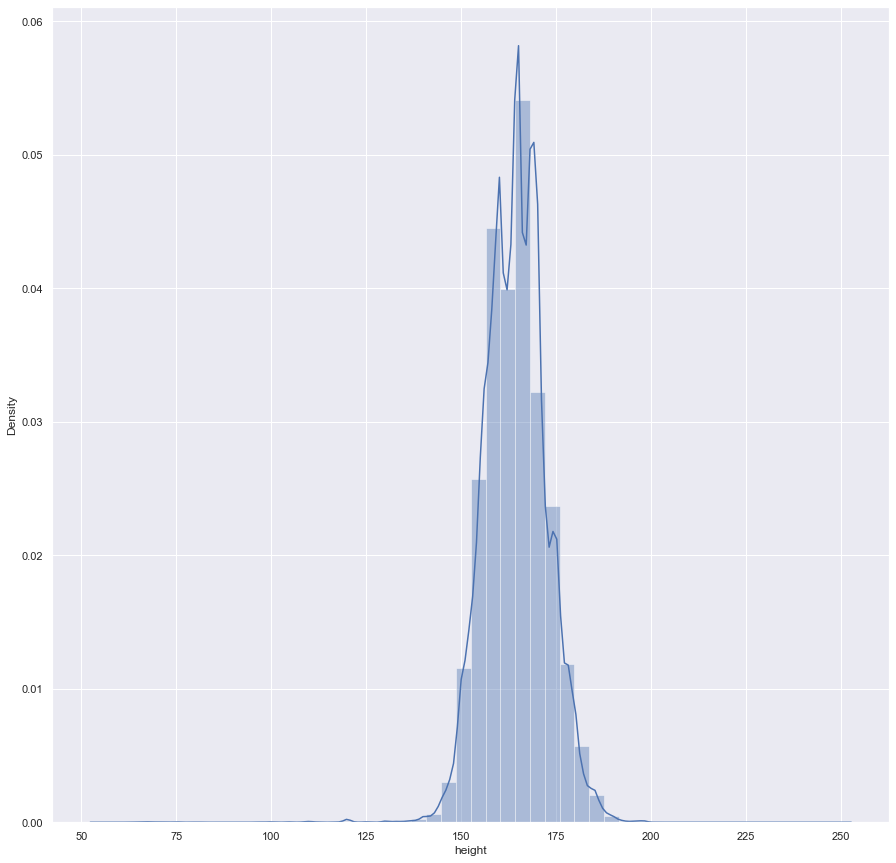

In [37]:
sns.set(rc={'figure.figsize':(15,15)})
sns.distplot(df['height'])

In [38]:
lo_height_outlier = df.loc[df['height'] < 125 ]
lo_height_outlier.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
224,59,2,76,55.0,120,80,1,1,0,0,1,0
3420,39,1,100,70.0,100,70,1,1,0,0,1,0
3735,48,1,120,70.0,120,70,1,1,0,0,1,0
3752,42,1,120,30.0,110,70,1,1,0,0,1,0
4212,44,1,120,80.0,120,80,1,1,0,0,1,0


In [39]:
hi_height_outlier = df.loc[df['height'] > 225 ]
hi_height_outlier

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
6486,58,1,250,86.0,140,100,3,1,0,0,1,1


In [40]:
df = df.drop(df[(df.height < 101)].index)

In [41]:
print('The data set is now {} rows.'.format(len(df)))
df.describe()

The data set is now 68722 rows.


,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
count,68722.000000,68722.000000,68722.000000,68722.000000,68722.000000,68722.000000,68722.000000,68722.000000,68722.000000,68722.000000,68722.000000,68722.000000
mean,52.829269,1.348797,164.399304,74.127265,126.620602,81.379369,1.364949,1.226158,0.088021,0.053651,0.803367,0.495009
std,6.768836,0.476593,7.975255,14.308166,16.766188,9.689589,0.679127,0.572135,0.283328,0.225329,0.397455,0.499979
min,29.000000,1.000000,104.000000,30.000000,60.000000,30.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,53.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,58.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,64.000000,2.000000,250.000000,200.000000,240.000000,190.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


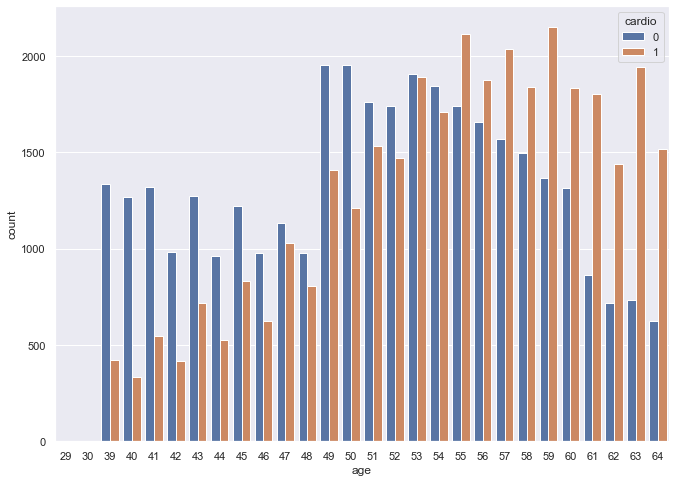

In [42]:
rcParams['figure.figsize'] = 11, 8
sns.countplot(x='age', hue='cardio', data = df);

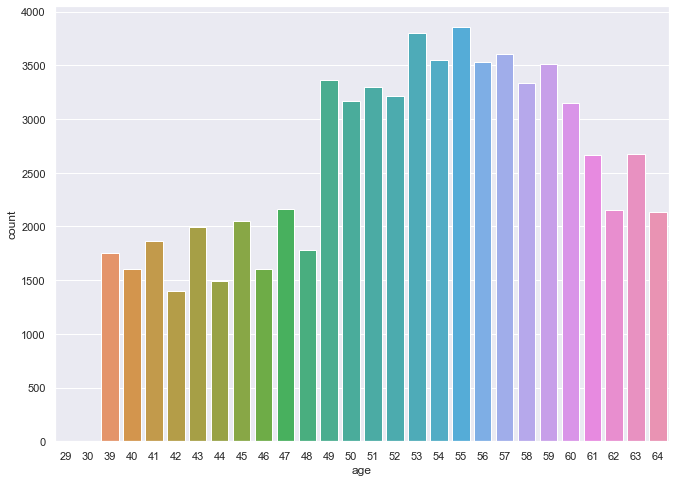

In [43]:
sns.countplot(x='age', data = df);

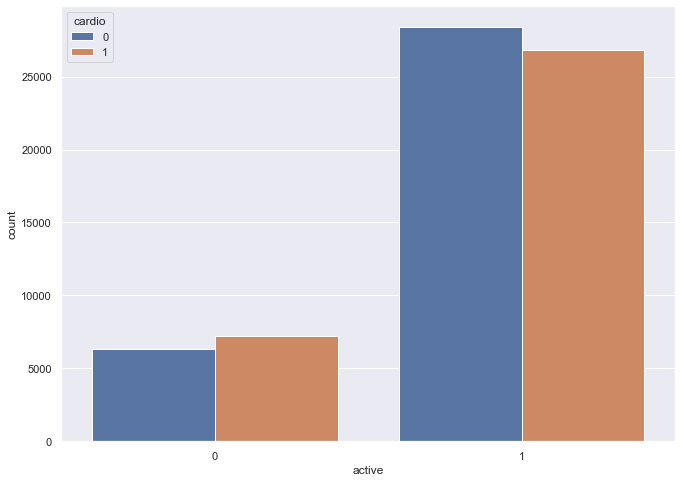

In [44]:
sns.countplot(x='active', hue='cardio', data = df);

<AxesSubplot:>

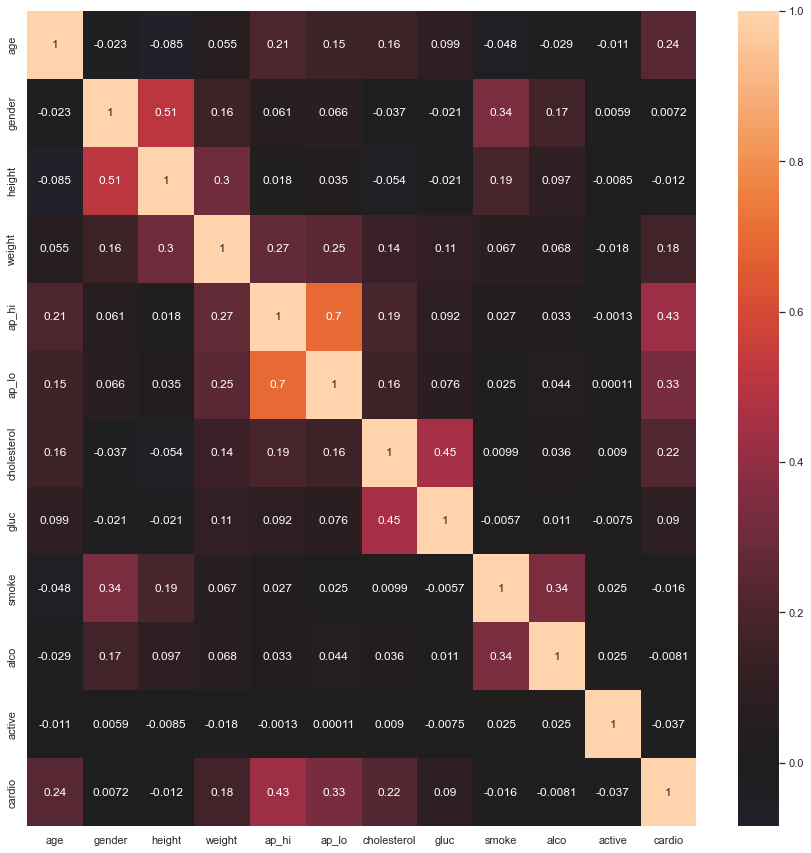

In [45]:
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(data=df.corr(), annot=True, center=0, ax=ax)

In [46]:
df["bmi"] = df["weight"]/ (df["height"]/100)**2
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
0,50,2,168,62.0,110,80,1,1,0,0,1,0,21.967120
1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.927679
2,51,1,165,64.0,130,70,3,1,0,0,0,1,23.507805
3,48,2,169,82.0,150,100,1,1,0,0,1,1,28.710479
4,47,1,156,56.0,100,60,1,1,0,0,0,0,23.011177


In [47]:
df['bmi'].describe()

count    68722.000000
mean        27.473686
std          5.343170
min         10.726644
25%         23.875115
50%         26.346494
75%         30.119376
max        152.551775
Name: bmi, dtype: float64

In [48]:
hi_bmi_outlier = df.loc[df['bmi'] > 55 ]
hi_bmi_outlier.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
338,57,1,157,142.0,120,80,1,1,0,0,1,1,57.608828
389,45,2,165,169.0,120,80,1,1,0,0,1,0,62.075298
435,45,1,186,200.0,130,70,1,1,0,0,0,0,57.810151
1598,44,1,160,150.0,120,80,2,1,0,0,1,1,58.593750
2340,57,1,160,150.0,160,75,1,1,0,0,1,1,58.593750


In [49]:
df = df.drop(df[(df.bmi > 55)].index)

In [50]:
lo_bmi_outlier = df.loc[df['bmi'] < 12]
lo_bmi_outlier

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,bmi
16906,47,2,170,31.0,150,90,2,2,0,0,1,1,10.726644
18559,49,1,160,30.0,120,80,1,1,0,0,1,1,11.718750


<AxesSubplot:>

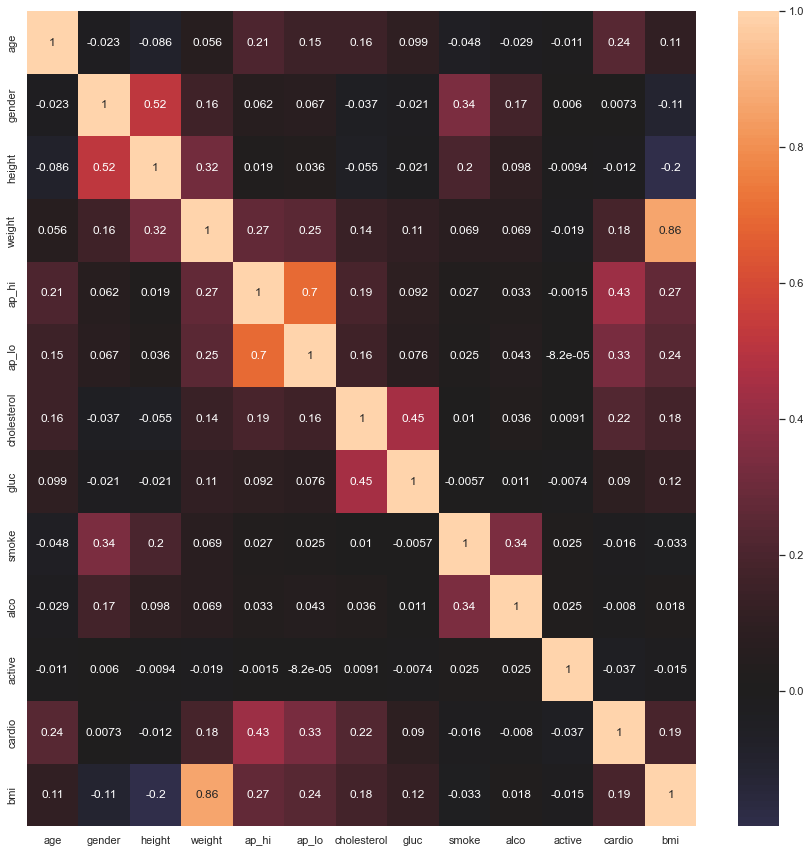

In [51]:
fig, ax = plt.subplots(figsize=(15,15)) 
sns.heatmap(data=df.corr(), annot=True, center=0, ax=ax)

Text(0.5, 1.0, 'AP_LO vs Cardio')

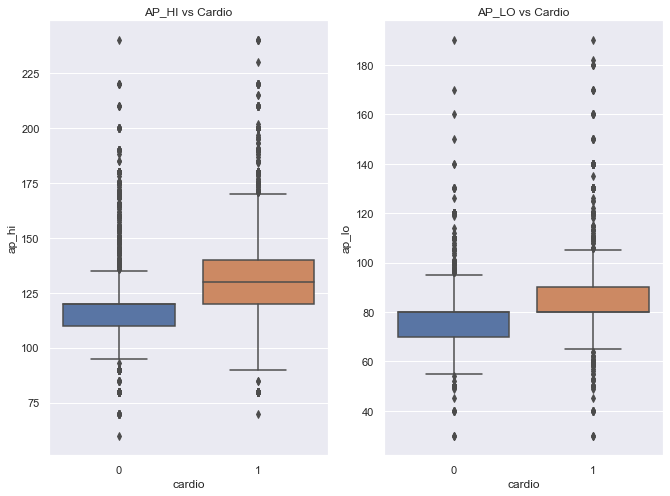

In [52]:
fig, axs = plt.subplots(1,2)
sns.boxplot(x='cardio',y='ap_hi',data= df, ax=axs[0]).set_title('AP_HI vs Cardio')
sns.boxplot(x='cardio',y='ap_lo',data= df, ax=axs[1]).set_title('AP_LO vs Cardio')

Text(0.5, 1.0, 'Age vs Cardio')

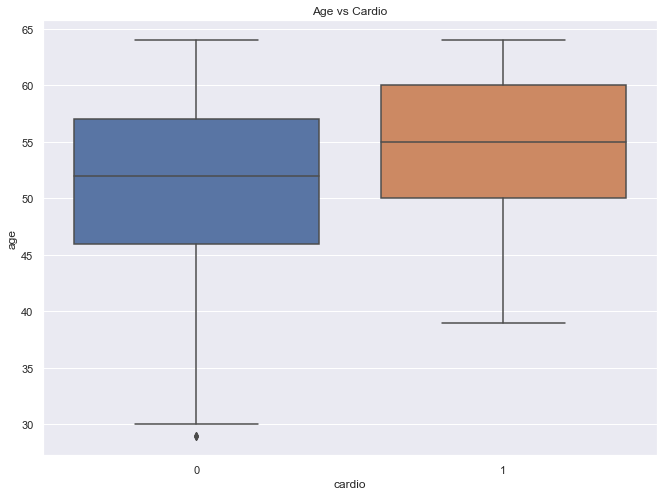

In [53]:
sns.boxplot(x='cardio',y='age',data= df).set_title("Age vs Cardio")

Text(0.5, 1.0, 'BMI vs Cardio')

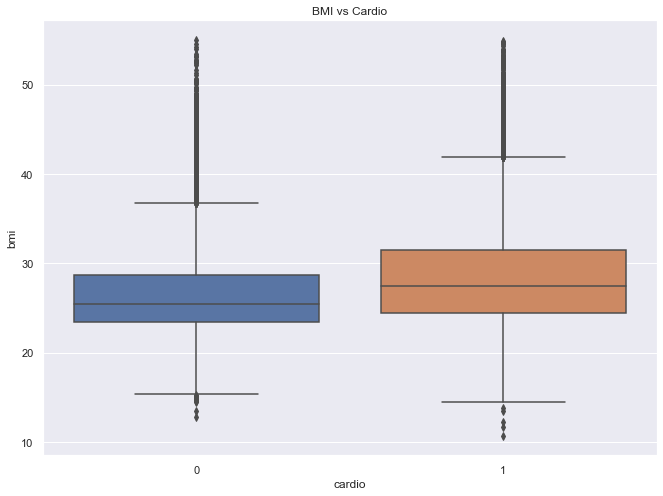

In [54]:
sns.boxplot(x='cardio',y='bmi',data= df).set_title('BMI vs Cardio')

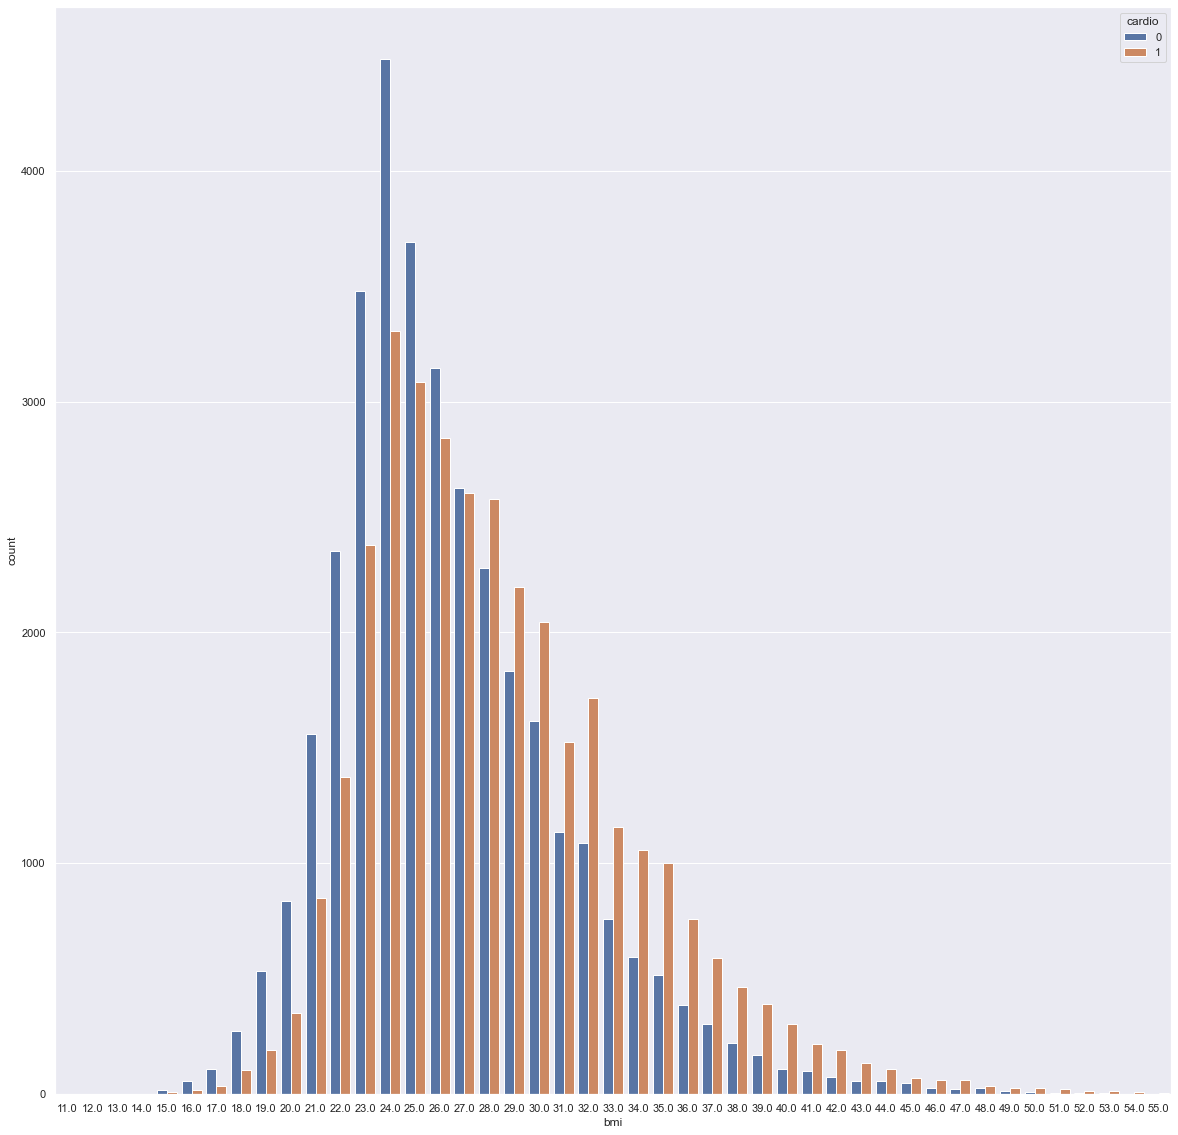

In [55]:
rcParams['figure.figsize'] = 20,20
tempbmi = round(df['bmi'],0)
tempbmi.describe()
sns.countplot(x= tempbmi, hue='cardio', data = df);

Text(0.5, 1.0, 'Cholestorol Counts')

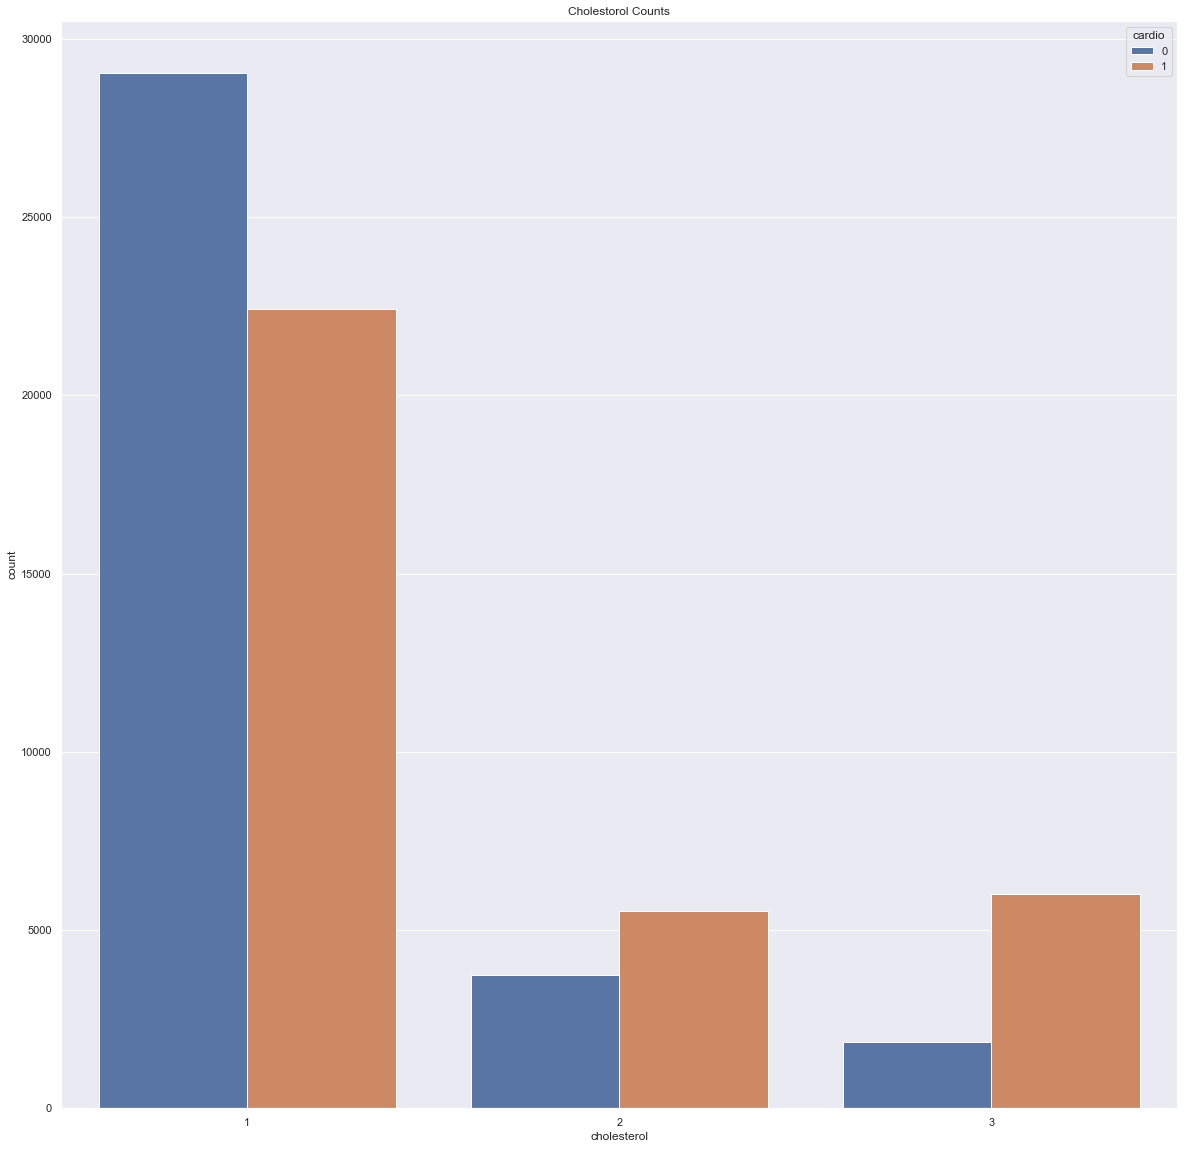

In [56]:
sns.countplot(x='cholesterol', hue='cardio', data=df).set_title('Cholestorol Counts')

In [57]:
y = df['cardio']
X = df.drop('cardio', axis=1)

In [58]:
X = X.apply(lambda x: ((x - min(x)) / (max(x) - min(x))), axis=0)

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [60]:
logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
model_log = logreg.fit(X_train, y_train)
model_log

LogisticRegression(C=1000000000000.0, fit_intercept=False, solver='liblinear')

In [61]:
y_pred_test = logreg.predict(X_test)
y_pred_train = logreg.predict(X_train)

In [62]:
a = precision_score(y_train, y_pred_train)
b = precision_score(y_test, y_pred_test)
c = recall_score(y_train, y_pred_train)
d = recall_score(y_test, y_pred_test)
e = accuracy_score(y_train, y_pred_train)
f = accuracy_score(y_test, y_pred_test)
g = f1_score(y_train, y_pred_train)
h = f1_score(y_test, y_pred_test)

In [63]:
print('Training Precision: ', round(a,4)* 100, '%')
print('Testing Precision: ', round(b,4)* 100, '%')
print('\n')

print('Training Recall: ', round(c,4)* 100, '%')
print('Testing Recall: ', round(d,4)* 100, '%')
print('\n')

print('Training Accuracy: ', round(e,4)* 100, '%')
print('Testing Accuracy: ', round(f,4)* 100, '%')
print('\n')

print('Training F1-Score: ', round(g,4)* 100, '%')
print('Testing F1-Score: ', round(h,4)* 100, '%')

Training Precision:  74.92 %
Testing Precision:  75.21 %


Training Recall:  66.78 %
Testing Recall:  67.67 %


Training Accuracy:  72.53 %
Testing Accuracy:  72.86 %


Training F1-Score:  70.62 %
Testing F1-Score:  71.24000000000001 %


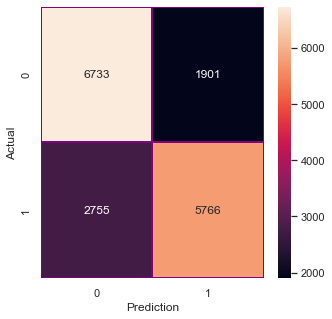

In [64]:
plot_confusion(y_test,y_pred_test)

In [65]:
print("For Test Set:")
print(classification_report(y_test,y_pred_test))

For Test Set:
              precision    recall  f1-score   support

           0       0.71      0.78      0.74      8634
           1       0.75      0.68      0.71      8521

    accuracy                           0.73     17155
   macro avg       0.73      0.73      0.73     17155
weighted avg       0.73      0.73      0.73     17155



In [66]:
y = df['cardio']
X = df.drop('cardio', axis=1)

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state=0)

In [68]:
sc_X = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

In [69]:
scaled_df = pd.DataFrame(X_train, columns=X.columns)

In [70]:
start = time.time()

logreg = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
model_log = logreg.fit(X_train, y_train)
#model_log

y_pred_test = logreg.predict(X_test)
y_pred_train = logreg.predict(X_train)

end = time.time()

print ('Time Taken:', end - start)

Time Taken: 0.09452652931213379


In [71]:
i = precision_score(y_train, y_pred_train)
lr_prec = precision_score(y_test, y_pred_test)
k = recall_score(y_train, y_pred_train)
lr_recall = recall_score(y_test, y_pred_test)
m = accuracy_score(y_train, y_pred_train)
lr_acc = accuracy_score(y_test, y_pred_test)
o = f1_score(y_train, y_pred_train)
p = f1_score(y_test, y_pred_test)

In [72]:
print('Training Precision: ', round(i,4)* 100, '%')
print('Testing Precision: ', round(lr_prec,4)* 100, '%')
print('\n')

print('Training Recall: ', round(k,4)* 100, '%')
print('Testing Recall: ', round(lr_recall,4)* 100, '%')
print('\n')

print('Training Accuracy: ', round(m,4)* 100, '%')
print('Testing Accuracy: ', round(lr_acc,4)* 100, '%')
print('\n')

print('Training F1-Score: ', round(o,4)* 100, '%')
print('Testing F1-Score: ', round(p,4)* 100, '%')

Training Precision:  75.46000000000001 %
Testing Precision:  75.75 %


Training Recall:  66.07 %
Testing Recall:  66.64 %


Training Accuracy:  72.61 %
Testing Accuracy:  72.83 %


Training F1-Score:  70.46 %
Testing F1-Score:  70.89999999999999 %


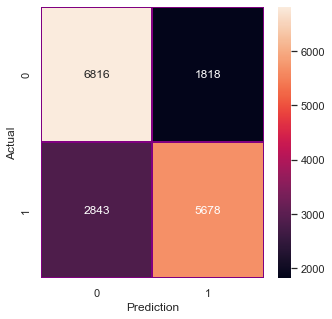

In [73]:
plot_confusion(y_test,y_pred_test)

In [74]:
print("For Test Set:")
lg_report = classification_report(y_test,y_pred_test)
print(lg_report)

For Test Set:
              precision    recall  f1-score   support

           0       0.71      0.79      0.75      8634
           1       0.76      0.67      0.71      8521

    accuracy                           0.73     17155
   macro avg       0.73      0.73      0.73     17155
weighted avg       0.73      0.73      0.73     17155



In [75]:
print('Testing Accuracy of Log Reg: ', round(lr_acc,4)* 100, '%')

Testing Accuracy of Log Reg:  72.83 %


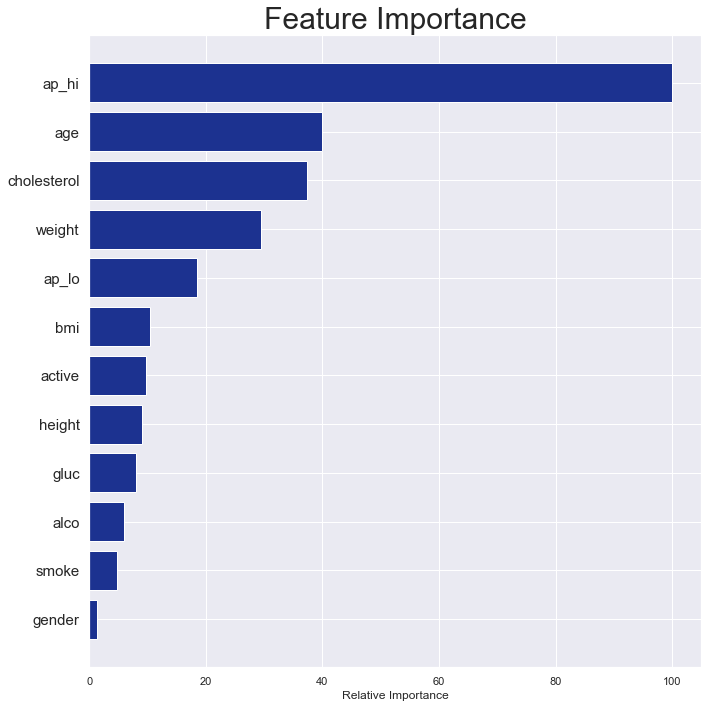

In [76]:
feature_importance = abs(model_log.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(10,10))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center', color='#1c3290')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=15)
featax.set_xlabel('Relative Importance')
featax.set_title("Feature Importance", fontsize=30)

plt.tight_layout()   
plt.show()

In [77]:
print('Testing Precision with Normalized: ', round(b,4)* 100, '%')
print('Testing Precision with Standardized: ', round(lr_prec,4)* 100, '%')
print('\n')

print('Testing Recall Normalized: ', round(d,4)* 100, '%')
print('Testing Recall Standardized: ', round(lr_recall,4)* 100, '%')
print('\n')

print('Testing Accuracy with Normalized: ', round(f,4)* 100, '%')
print('Testing Accuracy with Stardardized: ', round(lr_acc,4)* 100, '%')
print('\n')

print('Testing F1-Score with Normalized: ', round(h,4)* 100, '%')
print('Testing F1-Score with Standardized: ', round(p,4)* 100, '%')

Testing Precision with Normalized:  75.21 %
Testing Precision with Standardized:  75.75 %


Testing Recall Normalized:  67.67 %
Testing Recall Standardized:  66.64 %


Testing Accuracy with Normalized:  72.86 %
Testing Accuracy with Stardardized:  72.83 %


Testing F1-Score with Normalized:  71.24000000000001 %
Testing F1-Score with Standardized:  70.89999999999999 %


In [78]:
forest = RandomForestClassifier(n_estimators=100)
forest.fit(X_train, y_train)

RandomForestClassifier()

In [79]:
y_pred_test = forest.predict(X_test)
y_pred_train = forest.predict(X_train)

In [80]:
print("For Test Set:")
rf_report = classification_report(y_test, y_pred_test)
print(rf_report)

For Test Set:
              precision    recall  f1-score   support

           0       0.71      0.72      0.72      8634
           1       0.71      0.70      0.71      8521

    accuracy                           0.71     17155
   macro avg       0.71      0.71      0.71     17155
weighted avg       0.71      0.71      0.71     17155



In [81]:
rf_acc = forest.score(X_test,y_test)
print('Testing Accuracy of RF: ', round(rf_acc,4)* 100, '%')

Testing Accuracy of RF:  71.22 %


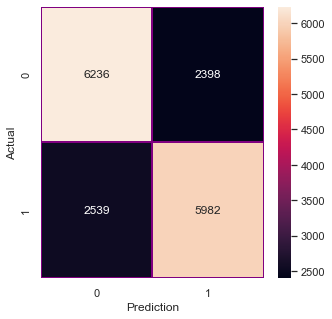

In [82]:
plot_confusion(y_test,y_pred_test)

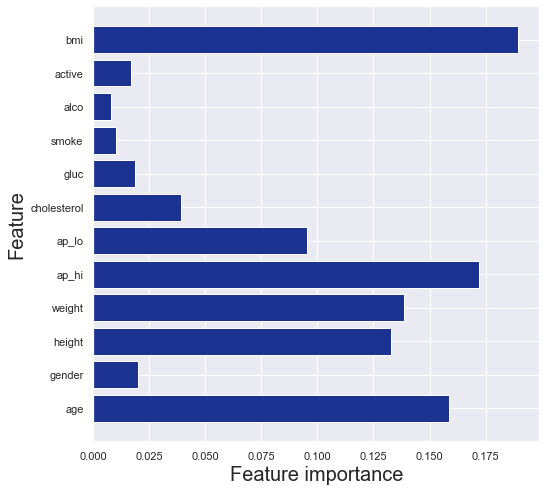

In [83]:
plot_feature_importances(forest)

In [84]:
knc = KNeighborsClassifier()

knc.fit(X_train, y_train)

y_pred_test = knc.predict(X_test)
y_pred_train = knc.predict(X_train)

In [85]:
knn_acc = accuracy_score(y_test, y_pred_test)
print('Testing Precision of KNN: ', round(precision_score(y_test, y_pred_test),4)* 100, '%')
print('Testing Recall of KNN: ', round(recall_score(y_test, y_pred_test),4)* 100, '%')
print('Testing Accuracy of KNN: ', round(knn_acc,4)*100, '%')
print('Testing F1-Score of KNN: ', round(f1_score(y_test, y_pred_test),4)*100, '%')

Testing Precision of KNN:  69.77 %
Testing Recall of KNN:  68.54 %
Testing Accuracy of KNN:  69.62 %
Testing F1-Score of KNN:  69.15 %


In [86]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.69      0.71      0.70      8634
           1       0.70      0.69      0.69      8521

    accuracy                           0.70     17155
   macro avg       0.70      0.70      0.70     17155
weighted avg       0.70      0.70      0.70     17155



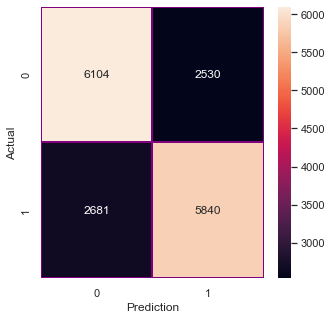

In [87]:
plot_confusion(y_test,y_pred_test)

In [88]:
y = df['cardio']
X = df.drop('cardio', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

std = StandardScaler()
X_train_transformed = std.fit_transform(X_train)
X_test_transformed = std.transform(X_test)

In [89]:
clf = SVC(probability=True)
clf.fit(X_train_transformed, y_train)

SVC(probability=True)

In [90]:
clf.score(X_test_transformed, y_test)

0.7347129116875547

In [91]:
y_pred_test= clf.predict(X_test_transformed)

In [92]:
print(classification_report(y_test,y_pred_test))

              precision    recall  f1-score   support

           0       0.71      0.79      0.75      8634
           1       0.76      0.68      0.72      8521

    accuracy                           0.73     17155
   macro avg       0.74      0.73      0.73     17155
weighted avg       0.74      0.73      0.73     17155



In [93]:
svm_acc = accuracy_score(y_test,y_pred_test)
print('Testing Accuracy of SVM: ', round(svm_acc,4)*100, '%')

Testing Accuracy of SVM:  73.47 %


In [94]:
svm_prec = precision_score(y_test,y_pred_test)
print('Testing Precision of SVM: ', round(svm_prec,4)*100, '%')

Testing Precision of SVM:  76.13 %


In [95]:
svm_recall = recall_score(y_test,y_pred_test)
print('Testing Recall of SVM: ', round(svm_recall,4)*100, '%')

Testing Recall of SVM:  67.88 %


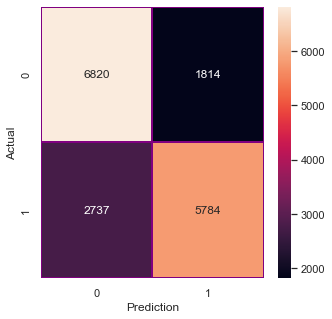

In [96]:
plot_confusion(y_test,y_pred_test)

In [97]:
model = ['LogReg','RF','KNN','SVM']
acc_performance = [lr_acc,rf_acc,knn_acc,svm_acc]

In [98]:
print(lr_acc)

0.7283007869425824


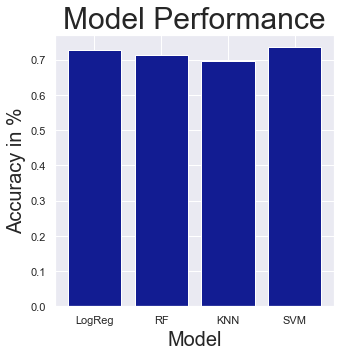

In [99]:
fig, ax = plt.subplots(figsize=(5,5))
plt.bar(model, acc_performance, color = '#121C92')
plt.title("Model Performance", fontsize = 30)
plt.xlabel("Model", fontsize=20)
plt.ylabel("Accuracy in %", fontsize = 20)
plt.show()

(array([0, 1, 2, 3]),
 [Text(0, 0, 'LogReg'),
  Text(1, 0, 'RF'),
  Text(2, 0, 'KNN'),
  Text(3, 0, 'SVM')])

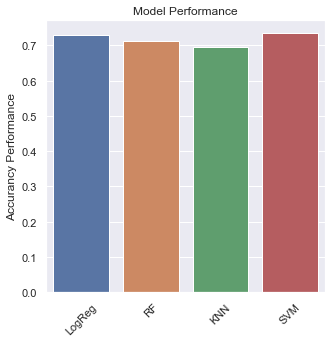

In [100]:
plt.figure(figsize=(5,5))
sns.barplot(x=model,y=acc_performance)
plt.ylabel('Accurancy Performance')
plt.title('Model Performance')
plt.xticks(rotation=45)

In [101]:
y = df['cardio']
X = df.drop('cardio', axis=1)

In [102]:
X = StandardScaler().fit_transform(X)

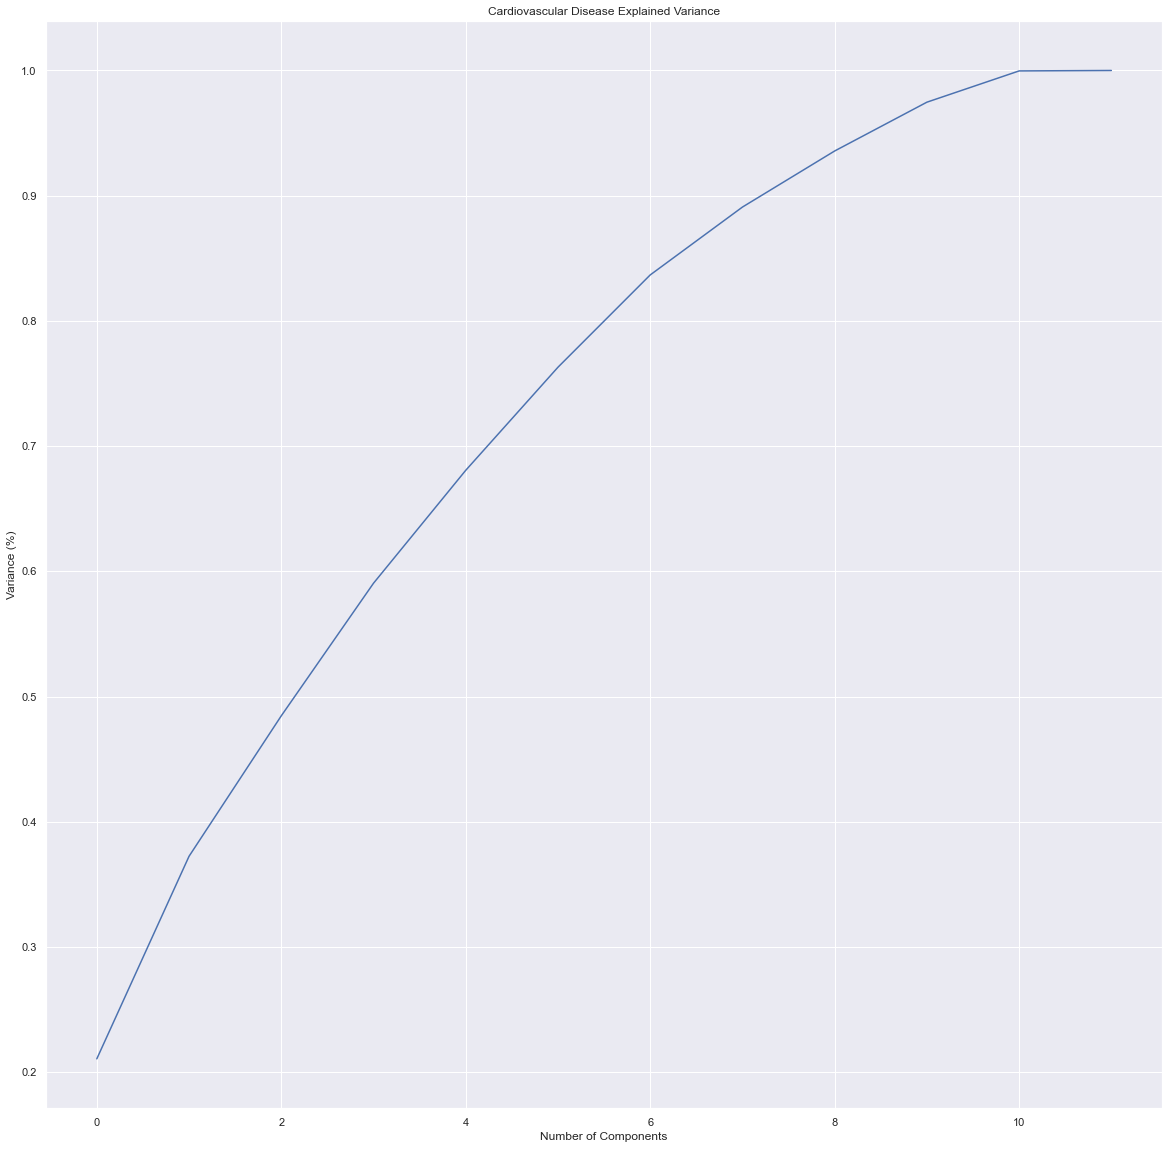

In [103]:
temppca = PCA().fit(X)

plt.figure()
plt.plot(np.cumsum(temppca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')
plt.title('Cardiovascular Disease Explained Variance')
plt.show()

In [104]:
# Instantiate PCA
pca2 = PCA(n_components=2)
pca10 = PCA(n_components=10)

# Fit PCA
principalComponents2 = pca2.fit_transform(X)
principalComponents10 = pca10.fit_transform(X)

In [105]:
pca_df2 = pd.DataFrame(data = principalComponents2, columns = ['PC1', 'PC2'])
pca_df10 = pd.DataFrame(data = principalComponents10, columns = ['PC1', 'PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10'])

target = pd.Series(df['cardio'], name='cardio')

In [106]:
print('Variance of each 2 components:', pca2.explained_variance_ratio_)
print('Total % Variance Explained for 2 components:', round(sum(list(pca2.explained_variance_ratio_))*100, 2))
print('\n')
print('Variance of each 10 components:', pca10.explained_variance_ratio_)
print('Total % Variance Explained for 10 components:', round(sum(list(pca10.explained_variance_ratio_))*100, 2))

Variance of each 2 components: [0.21061528 0.16176356]
Total % Variance Explained for 2 components: 37.24


Variance of each 10 components: [0.21061528 0.16176356 0.11217781 0.10590401 0.0901901  0.08233049
 0.07370657 0.05420854 0.04479609 0.03897824]
Total % Variance Explained for 10 components: 97.47


In [107]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(pca_df2, target, random_state=0)
X_train10, X_test10, y_train10, y_test10 = train_test_split(pca_df10, target, random_state=0)

In [108]:
start = time.time()

svm2 = SVC(probability=True)
svm2.fit(X_train2, y_train2)

y_pca_pred_test_svm2= svm2.predict(X_test2)

svm_acc2 = accuracy_score(y_test2,y_pca_pred_test_svm2)

end = time.time()

print ('Time Taken:', end - start)
print('Testing Accuracy of SVM with PCA =2: ', round(svm_acc2,4)*100, '%')

Time Taken: 767.3994915485382
Testing Accuracy of SVM with PCA =2:  68.66 %


In [109]:
svm_prec2 = precision_score(y_test2,y_pca_pred_test_svm2)
print('Testing Precision of SVM with PCA =2: ', round(svm_prec2,4)*100, '%')

svm_recall2 = recall_score(y_test2,y_pca_pred_test_svm2)
print('Testing Recall of SVM with PCA =2: ', round(svm_recall2,4)*100, '%')

Testing Precision of SVM with PCA =2:  68.99 %
Testing Recall of SVM with PCA =2:  67.03 %


In [110]:
start = time.time()

svm10 = SVC(probability=True)
svm10.fit(X_train10, y_train10)

y_pca_pred_test_svm10= svm10.predict(X_test10)

svm_acc10 = accuracy_score(y_test10,y_pca_pred_test_svm10)

end = time.time()

print ('Time Taken:', end - start)
print('Testing Accuracy of SVM with PCA =10: ', round(svm_acc10,4)*100, '%')

Time Taken: 690.0884001255035
Testing Accuracy of SVM with PCA =10:  72.98 %


In [111]:
svm_prec10 = precision_score(y_test10,y_pca_pred_test_svm10)
print('Testing Precision of SVM with PCA =10: ', round(svm_prec10,4)*100, '%')

svm_recall10 = recall_score(y_test10,y_pca_pred_test_svm10)
print('Testing Recall of SVM with PCA =10: ', round(svm_recall10,4)*100, '%')

Testing Precision of SVM with PCA =10:  75.69 %
Testing Recall of SVM with PCA =10:  67.16 %


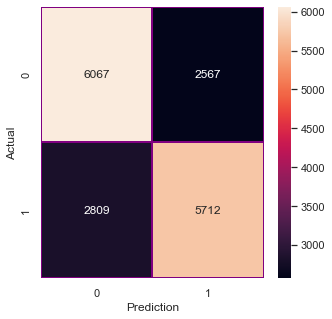

In [112]:
plot_confusion(y_test2, y_pca_pred_test_svm2)

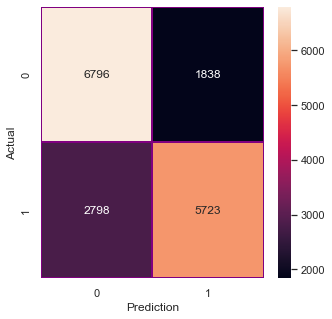

In [113]:
plot_confusion(y_test2, y_pca_pred_test_svm10)

In [114]:
knc2 = KNeighborsClassifier()
knc2.fit(X_train2, y_train2)
print(knc2)

knc10 = KNeighborsClassifier()
knc10.fit(X_train10, y_train10)
print(knc10)

KNeighborsClassifier()
KNeighborsClassifier()


In [115]:
y_pca_pred_test_knn2 = knc2.predict(X_test2)

knn_acc2 = round(accuracy_score(y_test2,y_pca_pred_test_knn2),4)
print('Testing Accuracy of KNN with PCA = 2: ', knn_acc2*100, '%')
knn_prec2 = precision_score(y_test2,y_pca_pred_test_knn2)
# print('Testing Precision of KNN with PCA =2: ', round(knn_prec2,4)*100, '%')

y_pca_pred_test_knn10 = knc10.predict(X_test10)
knn_acc10 = round(accuracy_score(y_test10,y_pca_pred_test_knn10),4)
print('Testing Accuracy of KNN with PCA = 10: ', knn_acc10*100, '%')
knn_prec10 = precision_score(y_test2,y_pca_pred_test_knn10)

Testing Accuracy of KNN with PCA = 2:  64.09 %
Testing Accuracy of KNN with PCA = 10:  69.19 %


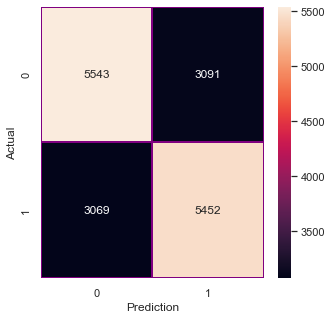

In [116]:
plot_confusion(y_test2, y_pca_pred_test_knn2)

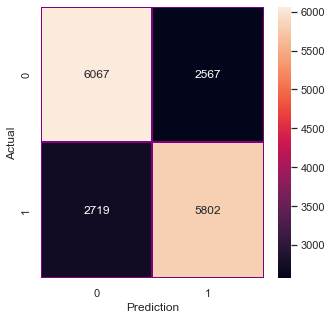

In [117]:
plot_confusion(y_test2, y_pca_pred_test_knn10)

In [118]:
logreg2 = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
model_log2 = logreg2.fit(X_train2, y_train2)

logreg10 = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
model_log10 = logreg10.fit(X_train10, y_train10)

In [119]:
y_pca_pred_test_logreg2 = logreg2.predict(X_test2)
y_pca_pred_test_logreg10 = logreg10.predict(X_test10)

In [121]:
start = time.time()
logreg2 = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
model_log2 = logreg2.fit(X_train2, y_train2)

y_pca_pred_test_logreg2 = logreg2.predict(X_test2)

lr_prec2 = precision_score(y_test2, y_pca_pred_test_logreg2)
lr_recall2 = recall_score(y_test2, y_pca_pred_test_logreg2)
lr_acc2 = accuracy_score(y_test2, y_pca_pred_test_logreg2)
# f1_score(y_test2, y_pca_pred_test_logreg2)

end = time.time()

print('Testing Accuracy of LogReg with PCA = 2: ', lr_acc2*100, '%')
print ('Time Taken:', end - start)

Testing Accuracy of LogReg with PCA = 2:  68.46983386767707 %
Time Taken: 0.05023360252380371


In [123]:
start = time.time()
logreg10 = LogisticRegression(fit_intercept=False, C=1e12, solver='liblinear')
model_log10 = logreg10.fit(X_train10, y_train10)

y_pca_pred_test_logreg10 = logreg10.predict(X_test10)

lr_prec10 = precision_score(y_test10, y_pca_pred_test_logreg10)
lr_recall10 = recall_score(y_test10, y_pca_pred_test_logreg10)
lr_acc10 = accuracy_score(y_test10, y_pca_pred_test_logreg10)
# f1_score(y_test10, y_pca_pred_test_logreg10)

end = time.time()

print('Testing Accuracy of LogReg with PCA = 2: ', lr_acc10*100, '%')
print ('Time Taken:', end - start)

Testing Accuracy of LogReg with PCA = 2:  72.44535120955989 %
Time Taken: 0.09699392318725586


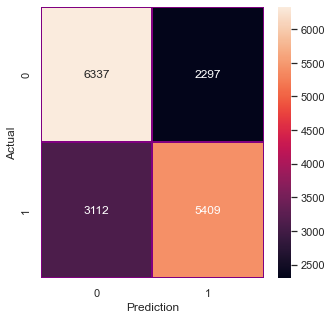

In [124]:
plot_confusion(y_test2, y_pca_pred_test_logreg2)


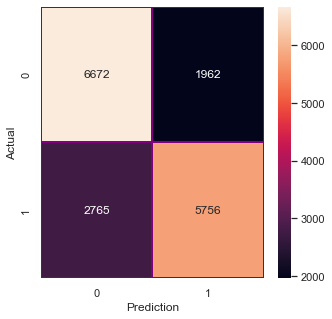

In [125]:
plot_confusion(y_test10, y_pca_pred_test_logreg10)

In [126]:
names = ['Log Reg','RF','KNN','SVM','KNN/pca=2','KNN/pca=10','Log Reg/pca=2','Log Reg/pca=10','SVM/pca=2','SVM/pca=10']
acc_performance = [lr_acc,rf_acc,knn_acc,svm_acc,knn_acc2,knn_acc10,lr_acc2,lr_acc10,svm_acc2,svm_acc10]

In [127]:
pca_names = ['SVM','KNN/pca=2','KNN/pca=10','Log Reg/pca=2','Log Reg/pca=10','SVM/pca=2','SVM/pca=10','Log Reg']
prec_performance = [svm_prec,knn_prec2,knn_prec10,lr_prec2,lr_prec10,svm_prec2,svm_prec10,lr_prec]

In [128]:
recall_names = ['SVM','Log Reg/pca=2','Log Reg/pca=10','SVM/pca=2','SVM/pca=10','Log Reg']
recall_performance = [svm_recall,lr_recall2,lr_recall10,svm_recall2,svm_recall10,lr_recall]

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'Log Reg'),
  Text(1, 0, 'RF'),
  Text(2, 0, 'KNN'),
  Text(3, 0, 'SVM'),
  Text(4, 0, 'KNN/pca=2'),
  Text(5, 0, 'KNN/pca=10'),
  Text(6, 0, 'Log Reg/pca=2'),
  Text(7, 0, 'Log Reg/pca=10'),
  Text(8, 0, 'SVM/pca=2'),
  Text(9, 0, 'SVM/pca=10')])

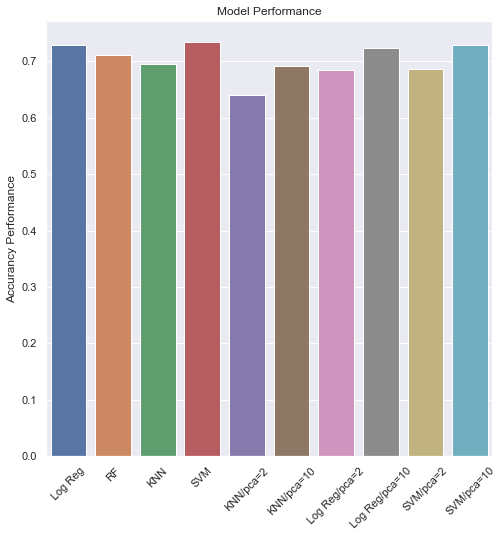

In [129]:
plt.figure(figsize=(8,8))
sns.barplot(x=names,y=acc_performance)
plt.ylabel('Accurancy Performance')
plt.title('Model Performance')
plt.xticks(rotation=45)

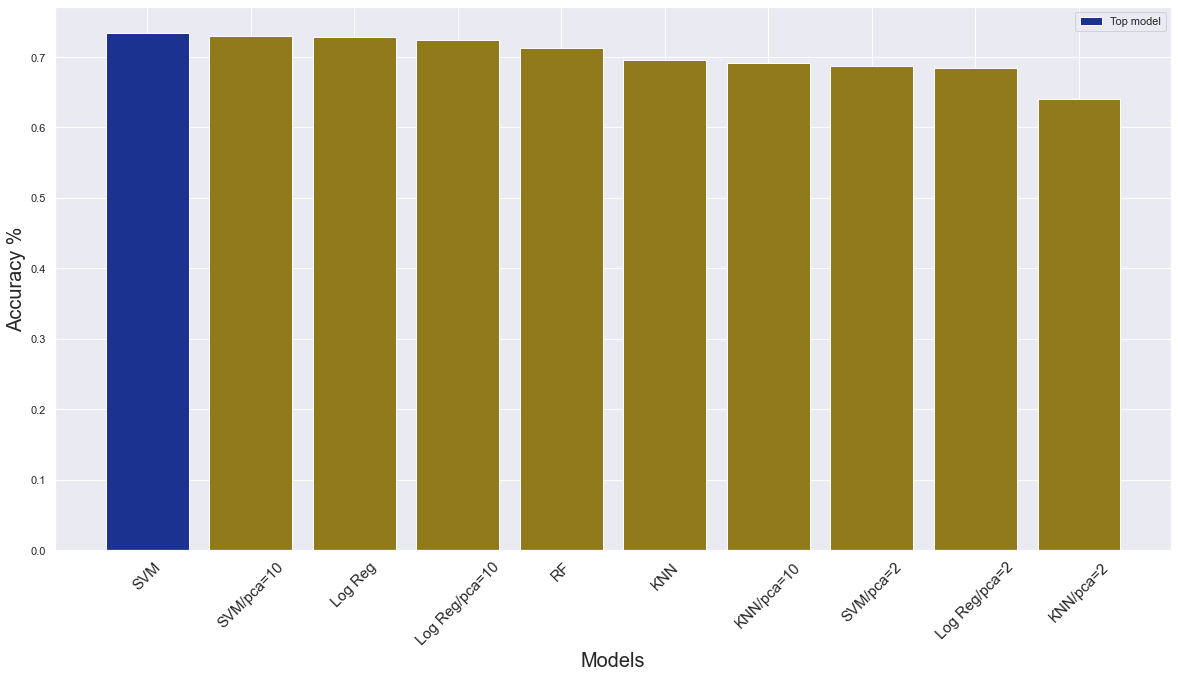

In [130]:
results(names,acc_performance,"Accuracy")

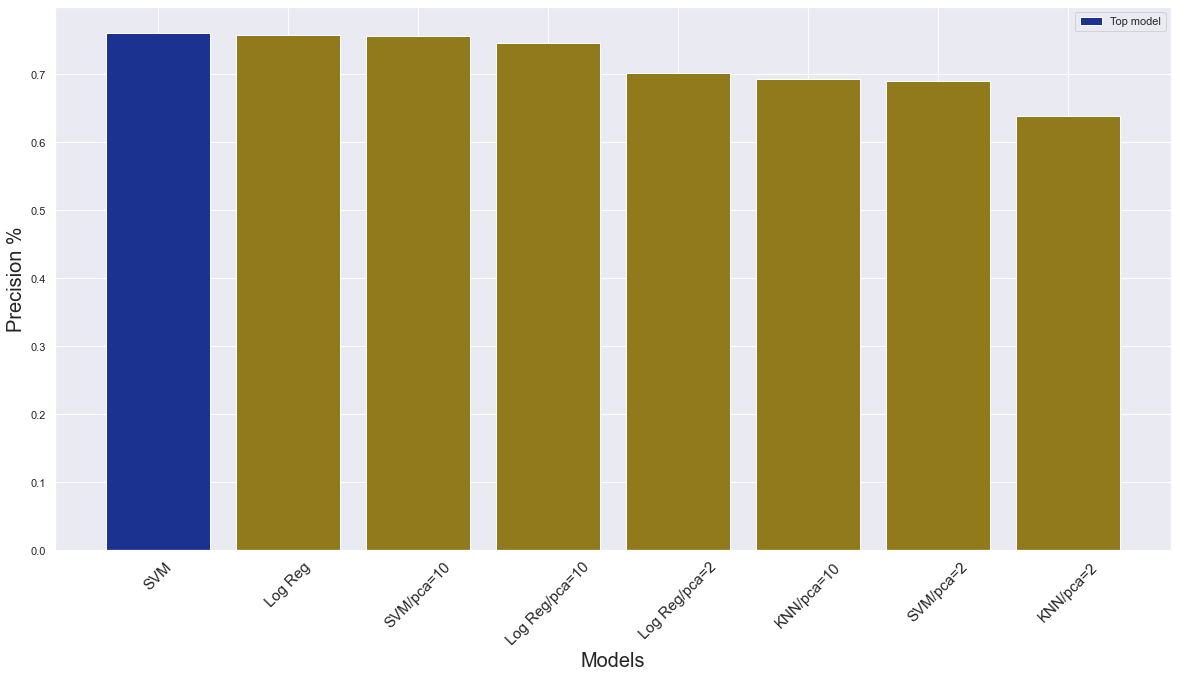

In [131]:
results(pca_names,prec_performance,"Precision")

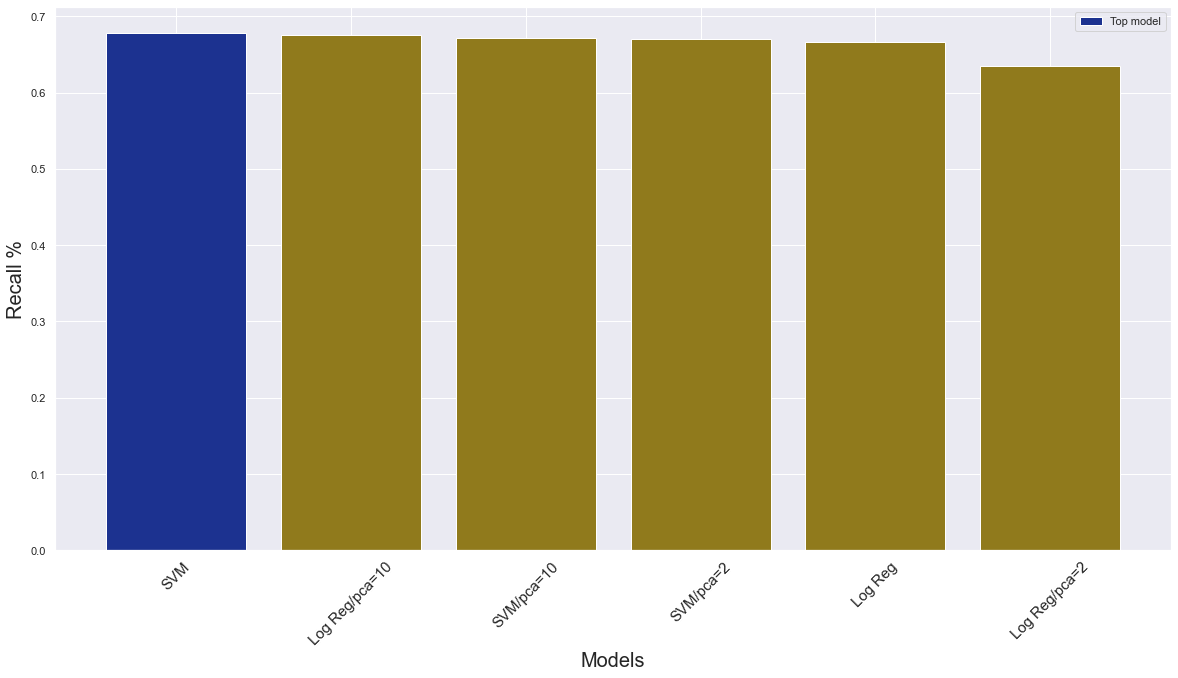

In [132]:
results(recall_names,recall_performance,"Recall")

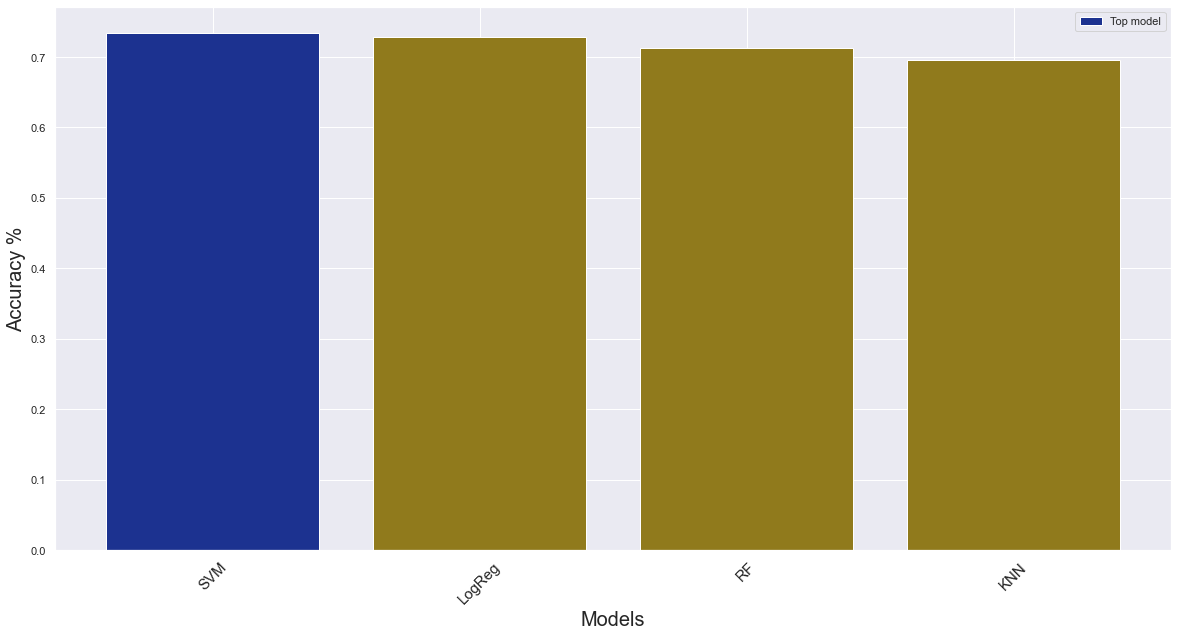

In [133]:
model = ['LogReg','RF','KNN','SVM']
acc_performance = [lr_acc,rf_acc,knn_acc,svm_acc]
results(model, acc_performance, "Accuracy")